# 1. Data Exploration & Quality Assessment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

sns.set(style="whitegrid")
%matplotlib inline

file_path = "rooster_a2_colours.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None)
customers   = sheets['customers']
orders      = sheets['orders']
products    = sheets['products']
orderlines  = sheets['orderlines']
metadata    = sheets['metadata']

for name, df in sheets.items():
    print(f"{name.upper():10s}  rows={df.shape[0]:5d}, cols={df.shape[1]:2d}")
    print(df.dtypes, "\n")


CUSTOMERS   rows= 5081, cols= 5
customer_email                       object
customer_first_order_date    datetime64[ns]
customer_last_order_date     datetime64[ns]
customer_total_orders                 int64
customer_total_spent                float64
dtype: object 

ORDERS      rows= 6126, cols=14
order_id                         object
customer_email                   object
order_date               datetime64[ns]
payment_method_title             object
shipping_method_title            object
order_subtotal                  float64
order_total                     float64
order_total_tax                 float64
order_shipping                  float64
order_refund                    float64
cart_discount                   float64
discount_amount                 float64
discount_amount_tax             float64
order_seq                         int64
dtype: object 

PRODUCTS    rows=  285, cols=13
product_id            object
range                 object
product_type          object
categ

In [ ]:
# 1) Merge orderlines with product metadata
orderlines_prod = (
    orderlines
    .merge(
        products[['product_id','variation_id','colour','product_name_main','pack_size','price']],
        on=['product_id','variation_id'],
        how='left'
    )
    .merge(
        orders[['order_id','order_date','order_total']],
        on='order_id', how='left'
    )
)

# 2) Quick sanity check
print(orderlines_prod.shape)
orderlines_prod.head()


(14140, 14)


,order_id,product_id,variation_id,sku,line_id,qty_minus_refund,item_price,item_price_before_discount,colour,product_name_main,pack_size,price,order_date,order_total
0,ord_d91efa5e,prd_2645072f,NaN,NaN,1,1,62.08,62.08,Custom,Rooster Trunks / Briefs (custom colour selecti...,7,104.3,2024-10-31,78.4
1,ord_d91efa5e,prd_f80af218,var_f1b78b7a,NaN,2,3,0.00,0.00,Black,Rooster Briefs Midnight in Eden Black,1,16.9,2024-10-31,78.4
2,ord_d91efa5e,prd_d53186bb,var_55ad458f,NaN,3,2,0.00,0.00,Blue,Rooster Briefs Jonah's Whale Blue,1,16.9,2024-10-31,78.4
3,ord_bba96567,prd_b33bcf92,NaN,NaN,1,1,12.17,39.75,Custom,Rooster Trunks / Briefs (custom colour selecti...,4,63.6,2024-10-31,18.5
4,ord_bba96567,prd_21e303b3,var_bd909c41,NaN,2,1,0.00,0.00,Red,Rooster Trunks Forbidden Fruit Red,1,16.9,2024-10-31,18.5


In [3]:
orderlines_prod[orderlines_prod['order_id'] == 'ord_bba96567']

,order_id,product_id,variation_id,sku,line_id,qty_minus_refund,item_price,item_price_before_discount,colour,product_name_main,pack_size,price,order_date,order_total
3,ord_bba96567,prd_b33bcf92,NaN,NaN,1,1,12.17,39.75,Custom,Rooster Trunks / Briefs (custom colour selecti...,4,63.6,2024-10-31,18.5
4,ord_bba96567,prd_21e303b3,var_bd909c41,NaN,2,1,0.00,0.00,Red,Rooster Trunks Forbidden Fruit Red,1,16.9,2024-10-31,18.5
5,ord_bba96567,prd_19bfea07,var_fdd918ee,NaN,3,1,0.00,0.00,Blue,Rooster Trunks Jonah's Whale Blue,1,16.9,2024-10-31,18.5
6,ord_bba96567,prd_747b60b4,var_63fc3521,NaN,4,1,0.00,0.00,Purple,Rooster Trunks Purple Silk Veil,1,16.9,2024-10-31,18.5
7,ord_bba96567,prd_8ec221b4,var_fb403193,NaN,5,1,0.00,14.08,Green,Rooster Trunks Temptation of the Snake Green,1,16.9,2024-10-31,18.5


In [4]:
def report_quality(df, name):
    print(f"--- {name} ---")
    print("Missing values:\n", df.isnull().sum())
    print("Duplicates:", df.duplicated().sum(), "\n")

for name, df in sheets.items():
    report_quality(df, name)


--- customers ---
Missing values:
 customer_email               0
customer_first_order_date    0
customer_last_order_date     0
customer_total_orders        0
customer_total_spent         0
dtype: int64
Duplicates: 0 

--- orders ---
Missing values:
 order_id                    0
customer_email              0
order_date                  0
payment_method_title        1
shipping_method_title       5
order_subtotal              0
order_total                 0
order_total_tax             0
order_shipping              0
order_refund                0
cart_discount               0
discount_amount          4005
discount_amount_tax      4005
order_seq                   0
dtype: int64
Duplicates: 0 

--- products ---
Missing values:
 product_id             0
range                  0
product_type           0
category               0
pack_size              0
product_name_main      0
product_name           0
size                  27
variation_id          27
sku                  280
price           

- Our `customer` sheet has no missing values, which proves to be a reliable source for further calculations
- For our `orders` sheet, we have very little missing values for `payment` and `shipping` method title, which we can safely impute to "Unknown" or "Others". However, we have approximately ~65% of orders with missing discount values, which we can interpret as no discount applied.
- In our `products` sheet, 280 out of 285 products have no SKU, which means we will ignore `sku`.


In [5]:
missing_orders = set(orderlines['order_id']) - set(orders['order_id'])
print("Missing orderlines:", len(missing_orders))

missing_prods  = set(orderlines['product_id']) - set(products['product_id'])
print("Missing products:", len(missing_prods))

Missing orderlines: 0
Missing products: 0


We then checked for referential integrity to join the dataframes, and there appears to be no missing values.

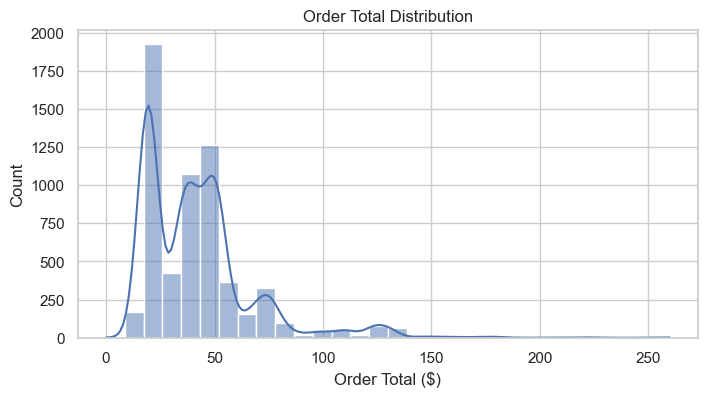

In [6]:
plt.figure(figsize=(8,4))
sns.histplot(orders['order_total'], bins=30, kde=True)
plt.title("Order Total Distribution")
plt.xlabel("Order Total ($)")
plt.show()

Most orders seem to lie within the $10-$50 range, with the highest amounts of order in the $20 range

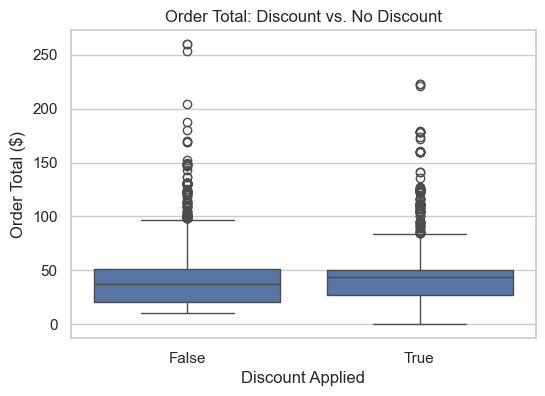

In [7]:
orders['has_discount'] = orders['discount_amount'].notna()
plt.figure(figsize=(6,4))
sns.boxplot(x='has_discount', y='order_total', data=orders)
plt.title("Order Total: Discount vs. No Discount")
plt.xlabel("Discount Applied")
plt.ylabel("Order Total ($)")
plt.show()

We can see that order with a discount have a slightly higher median spend than non-discounted orders, suggesting that discounts **do** drive up the **average basket price**.

Another thing to note is that the interquartile range and range of discounted orders are larger, meaning that some discounted orders still come very low, but they also climb very high, higher than that of their non-discounted counterpart.

# Descriptive analysis

In [8]:
orderlines_prod.head()

,order_id,product_id,variation_id,sku,line_id,qty_minus_refund,item_price,item_price_before_discount,colour,product_name_main,pack_size,price,order_date,order_total
0,ord_d91efa5e,prd_2645072f,NaN,NaN,1,1,62.08,62.08,Custom,Rooster Trunks / Briefs (custom colour selecti...,7,104.3,2024-10-31,78.4
1,ord_d91efa5e,prd_f80af218,var_f1b78b7a,NaN,2,3,0.00,0.00,Black,Rooster Briefs Midnight in Eden Black,1,16.9,2024-10-31,78.4
2,ord_d91efa5e,prd_d53186bb,var_55ad458f,NaN,3,2,0.00,0.00,Blue,Rooster Briefs Jonah's Whale Blue,1,16.9,2024-10-31,78.4
3,ord_bba96567,prd_b33bcf92,NaN,NaN,1,1,12.17,39.75,Custom,Rooster Trunks / Briefs (custom colour selecti...,4,63.6,2024-10-31,18.5
4,ord_bba96567,prd_21e303b3,var_bd909c41,NaN,2,1,0.00,0.00,Red,Rooster Trunks Forbidden Fruit Red,1,16.9,2024-10-31,18.5



=== Stats by Colour ===
   colour  sales_volume   revenue  avg_order_value
0   Black          5907  159765.6        67.415663
1    Blue          3039   58739.8        69.033674
2   Green          1483   26772.6        72.120103
3  Purple           369    6282.8        81.154833
4     Red          2684   50447.3        67.319259
5   White          1260   24036.0        63.847488

% orders with >1 item: 53.6%

Proportion of orders by # distinct colours:
   num_colours  proportion
0            1    0.524323
1            3    0.225106
2            2    0.182338
3            4    0.041299
4            5    0.023506
5            6    0.002612
6            0    0.000816


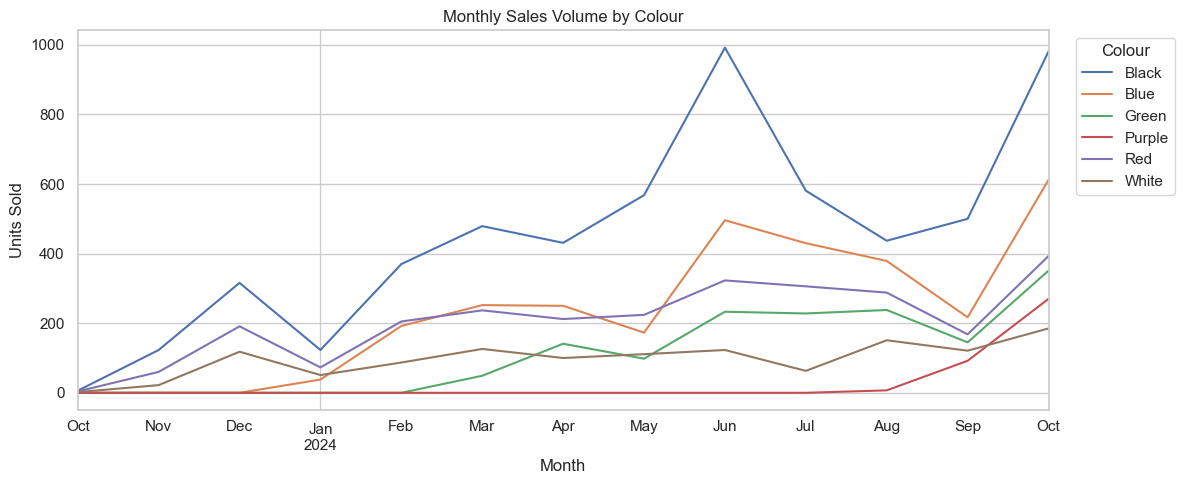

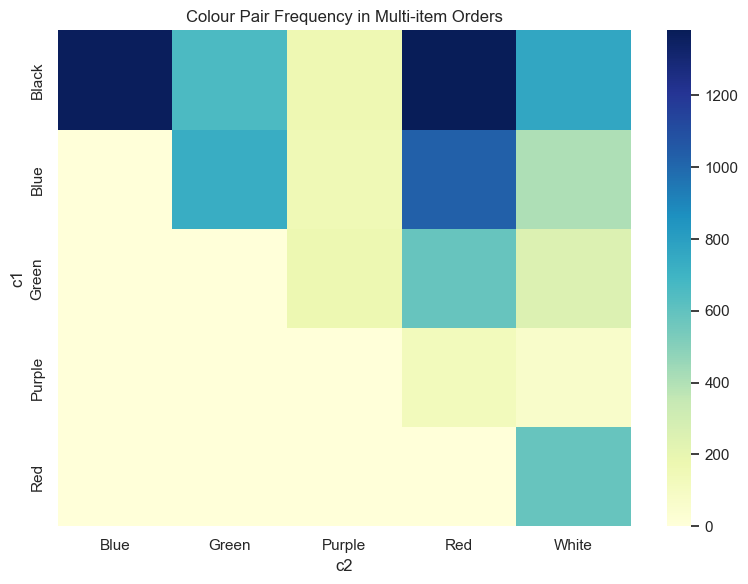

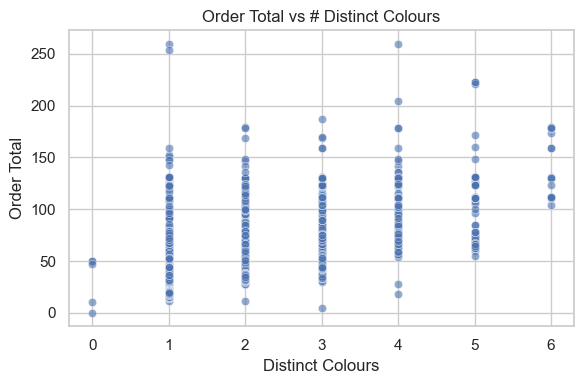

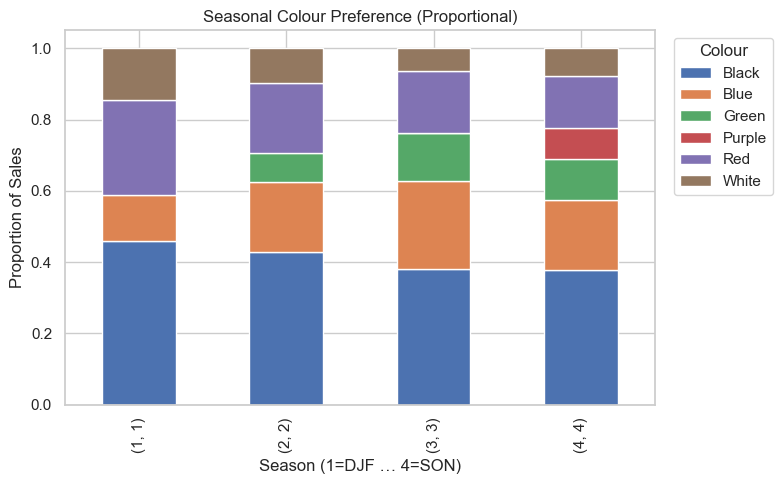

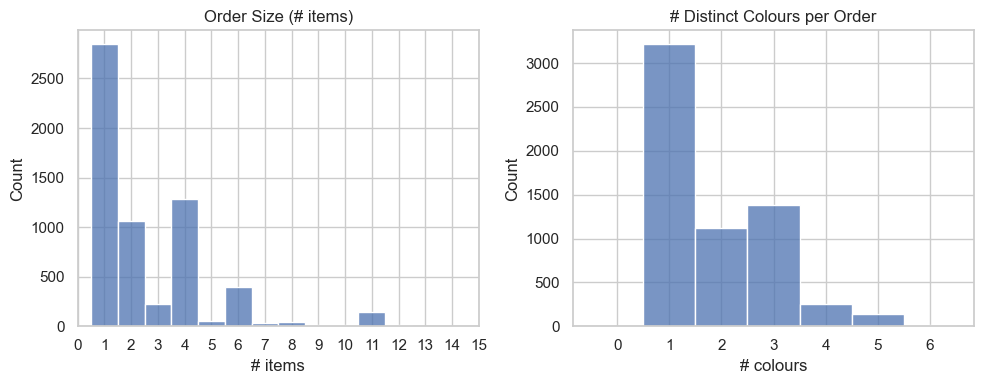


Correlation between colour presence & order size:
colour
NaN       0.708459
Red       0.436182
Green     0.418115
Blue      0.366904
White     0.332859
Purple    0.292393
Black     0.253812
Name: total_items, dtype: float64

Top Colours by Cumulative Revenue %:
   colour   revenue     cum_pct
0   Black  159765.6   49.001224
1    Blue   58739.8   67.017131
4     Red   50447.3   82.489669
2   Green   26772.6   90.701013
5   White   24036.0   98.073021
3  Purple    6282.8  100.000000


In [9]:
sns.set(style="whitegrid")
%matplotlib inline

# --- 0) assume orderlines_prod already exists ---
df = orderlines_prod.copy()

# --- 1) Explode Custom bundles into real colours ---
# 1a) isolate custom rows
cust_mask = df['colour'].str.lower() == 'custom'
custom = df[cust_mask].copy()

df['line_revenue'] = df['item_price'] * df['qty_minus_refund']

# 1b) parse list of chosen colours from product_name_main
custom['chosen_colours'] = (
    custom['product_name_main']
          .str.extract(r':\s*(.*)$')[0]
          .str.split(r',\s*')
)

# 1c) drop the placeholder colour column, explode & rename
custom = custom.drop(columns=['colour'])
exploded = (
    custom
    .explode('chosen_colours')
    .rename(columns={'chosen_colours':'colour'})
)
exploded['qty_minus_refund'] = exploded['qty_minus_refund']  # keep quantity
exploded['line_revenue'] = exploded['qty_minus_refund'] * exploded['price']

# 1d) keep all non-custom rows
non_custom = df[~cust_mask].copy()
non_custom['line_revenue'] = non_custom['qty_minus_refund'] * non_custom['price']

# 1e) combine into a new DataFrame for analysis
df2 = pd.concat([non_custom, exploded], ignore_index=True)

# now drop any remnant placeholder  
df2 = df2[df2['colour'].str.lower() != 'custom']

# parse dates/months etc.
df2['order_date']  = pd.to_datetime(df2['order_date'])
df2['order_month'] = df2['order_date'].dt.to_period('M')
df2['season']      = df2['order_date'].dt.month % 12 // 3 + 1

# --- 2) Descriptive stats by colour ---
stats_by_colour = (
    df2
    .groupby('colour')
    .agg(
        sales_volume=('qty_minus_refund','sum'),
        revenue=('line_revenue','sum'),
        avg_order_value=('order_total',
                         lambda x: x.drop_duplicates().mean())
    )
    .reset_index()
)
print("\n=== Stats by Colour ===")
print(stats_by_colour)

# --- 3) Order-level metrics ---
orders_items = (
    df2
    .groupby('order_id')
    .agg(
        total_items=('qty_minus_refund','sum'),
        distinct_colours=('colour','nunique'),
        order_total=('order_total','first')
    )
    .reset_index()
)

pct_multi = (orders_items['total_items'] > 1).mean()*100
print(f"\n% orders with >1 item: {pct_multi:.1f}%")

prop = (
    orders_items['distinct_colours']
    .value_counts(normalize=True)
    .rename_axis('num_colours')
    .reset_index(name='proportion')
)
print("\nProportion of orders by # distinct colours:")
print(prop)

# --- 4) Visualisations ---

# a) Monthly colour sales trends
monthly = (
    df2.groupby(['order_month','colour'])['qty_minus_refund']
       .sum()
       .unstack(fill_value=0)
)
monthly.plot(figsize=(12,5))
plt.title("Monthly Sales Volume by Colour")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend(title="Colour", bbox_to_anchor=(1.02,1))
plt.tight_layout()

# b) Colour-pair heatmap for multi-item orders
pairs = []
for oid, grp in df2.groupby('order_id'):
    # only look at orders with >1 item
    if grp['qty_minus_refund'].sum() <= 1:
        continue

    # drop any nulls and make sure every colour is a string
    cols = grp['colour'].dropna().astype(str).unique()
    if len(cols) < 2:
        continue

    # now safe to sort and build pairs
    for c1, c2 in combinations(sorted(cols), 2):
        pairs.append((c1, c2))

pairs_df = pd.DataFrame(pairs, columns=['c1','c2'])
heat = pairs_df.groupby(['c1','c2']).size().unstack(fill_value=0)

plt.figure(figsize=(8,6))
sns.heatmap(heat, cmap="YlGnBu")
plt.title("Colour Pair Frequency in Multi-item Orders")
plt.tight_layout()

# c) Order size vs order value
plt.figure(figsize=(6,4))
sns.scatterplot(data=orders_items, x='distinct_colours', y='order_total', alpha=0.6)
plt.title("Order Total vs # Distinct Colours")
plt.xlabel("Distinct Colours")
plt.ylabel("Order Total")
plt.tight_layout()

# --- 5) Seasonal preferences (stacked bar) ---
sns.set(style="whitegrid")

# 1) Compute a “season” column: 1=DJF, 2=MAM, 3=JJA, 4=SON
df2['season'] = df2['order_date'].dt.month % 12 // 3 + 1

# 2) Aggregate & normalize to get proportions per season
seasonal = (
    df2
    .groupby(['season','colour'])['qty_minus_refund']
    .sum()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
)

# 3) Plot as a stacked bar chart
plt.figure(figsize=(8,5))
seasonal.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title("Seasonal Colour Preference (Proportional)")
plt.xlabel("Season (1=DJF … 4=SON)")
plt.ylabel("Proportion of Sales")
plt.legend(title="Colour", bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

# --- 6) Basket distributions ---
fig, axes = plt.subplots(1,2,figsize=(10,4))

# Order size histogram (0–15)
sns.histplot(orders_items['total_items'], 
             ax=axes[0], 
             discrete=True,
             binwidth=1)
axes[0].set(
    title="Order Size (# items)", 
    xlabel="# items",
    xlim=(0, 15),
    xticks=range(0, 16)
)

# Distinct colours histogram (leave as before)
sns.histplot(orders_items['distinct_colours'], 
             ax=axes[1], 
             discrete=True,
             binwidth=1)
axes[1].set(
    title="# Distinct Colours per Order", 
    xlabel="# colours"
)

plt.tight_layout()
plt.show()


# --- 7) Correlation colour presence vs order size ---
onehot = (
    df2.drop_duplicates(['order_id','colour'])
       .assign(presence=1)
       .pivot(index='order_id', columns='colour', values='presence')
       .fillna(0)
)
onehot['total_items'] = orders_items.set_index('order_id')['total_items']
corr = onehot.corr()['total_items'].drop('total_items').sort_values(ascending=False)
print("\nCorrelation between colour presence & order size:")
print(corr)

# --- 8) Top-colour revenue contribution ---
top_rev = (
    stats_by_colour
    .sort_values('revenue', ascending=False)
    .assign(cum_pct = lambda d: d['revenue'].cumsum() / d['revenue'].sum() * 100)
)
print("\nTop Colours by Cumulative Revenue %:")
print(top_rev[['colour','revenue','cum_pct']])

# Basic predictive modelling

In [58]:
import pandas as pd

# 1) Load all sheets
file_path = "rooster_a2_colours.xlsx"
xls = pd.ExcelFile(file_path)
orders     = pd.read_excel(xls, 'orders')
orderlines = pd.read_excel(xls, 'orderlines')
products   = pd.read_excel(xls, 'products')

# 2) Merge orderlines with key product fields
orderlines_prod = orderlines.merge(
    products[['product_id','variation_id','colour','product_name_main','pack_size','price']],
    on=['product_id','variation_id'],
    how='left'
)

# 3) Explode “Custom” bundles into their true colours
df = orderlines_prod.copy()
cust_mask = df['colour'].str.lower() == 'custom'

# a) Parse the chosen colours list
custom = df[cust_mask].copy()
custom['chosen_colours'] = (
    custom['product_name_main']
          .str.extract(r':\s*(.*)$')[0]  # text after the colon
          .str.split(r',\s*')            # split into Python list
)

# b) Drop the placeholder “Custom” column and explode
custom = custom.drop(columns=['colour'])
exploded = custom.explode('chosen_colours') \
                 .rename(columns={'chosen_colours':'colour'})

# 4) Keep all non-custom lines
non_custom = df[~cust_mask].copy()

# 5) Combine and drop any remnant “Custom” rows
df2 = pd.concat([non_custom, exploded], ignore_index=True)
df2 = df2[df2['colour'].str.lower() != 'custom']

# 6) (Optional) Preview
print(df2.head())


       order_id    product_id  variation_id  sku  line_id  qty_minus_refund  \
0  ord_d91efa5e  prd_f80af218  var_f1b78b7a  NaN        2                 3   
1  ord_d91efa5e  prd_d53186bb  var_55ad458f  NaN        3                 2   
2  ord_bba96567  prd_21e303b3  var_bd909c41  NaN        2                 1   
3  ord_bba96567  prd_19bfea07  var_fdd918ee  NaN        3                 1   
4  ord_bba96567  prd_747b60b4  var_63fc3521  NaN        4                 1   

   item_price  item_price_before_discount  colour  \
0         0.0                         0.0   Black   
1         0.0                         0.0    Blue   
2         0.0                         0.0     Red   
3         0.0                         0.0    Blue   
4         0.0                         0.0  Purple   

                       product_name_main  pack_size  price  
0  Rooster Briefs Midnight in Eden Black          1   16.9  
1      Rooster Briefs Jonah's Whale Blue          1   16.9  
2     Rooster Trunks Fo

In [68]:
import pandas as pd
from collections import Counter
from pycaret.classification import setup, compare_models, finalize_model, predict_model

# --- 0) Clean up df2 colours ---
df2 = df2[df2['colour'].notnull()].copy()
df2['colour'] = df2['colour'].astype(str)

# --- 1) Build next-item dataset ---
# df2 must have columns: order_id, line_id, colour, qty_minus_refund (and any others)
records = []
all_colours = sorted(df2['colour'].unique())

for oid, grp in df2.sort_values(['order_id','line_id']).groupby('order_id'):
    # expand each order into multiple training examples:
    # if an order has N items, we get N-1 rows: predict item i from items [0..i-1]
    colours = grp['colour'].tolist()
    for i in range(1, len(colours)):
        curr = colours[:i]
        nxt  = colours[i]
        counts = Counter(curr)
        # build one-hot features (or counts) for every colour
        rec = {f"has_{c}": counts.get(c, 0) for c in all_colours}
        rec['next_colour'] = nxt
        records.append(rec)

train_df = pd.DataFrame(records)

# --- 2) PyCaret setup & model selection ---
exp = setup(
    data=train_df,
    target='next_colour',
    session_id=42,
    fold_strategy='stratifiedkfold',
    fold=5,
    verbose=False,
    # list your numeric one-hot features explicitly if PyCaret doesn’t infer them:
    numeric_features=[f"has_{c}" for c in all_colours]
)

# benchmark and pick the best classifier
best_clf = compare_models()

# finalize the chosen model
final_clf = finalize_model(best_clf)

# --- 3) Predicting for a new basket ---
# e.g. user has ['Black','Blue','White'] in basket so far
new_basket = ['Black','Blue','White']
counts = Counter(new_basket)
new_rec = {f"has_{c}": counts.get(c, 0) for c in all_colours}
new_df  = pd.DataFrame([new_rec])

pred = predict_model(final_clf, data=new_df)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5172,0.7848,0.5172,0.5461,0.4992,0.3660,0.3804,0.0540
rf,Random Forest Classifier,0.5165,0.7881,0.5165,0.5433,0.4988,0.3657,0.3792,0.0640
dt,Decision Tree Classifier,0.5159,0.7798,0.5159,0.5429,0.4977,0.3642,0.3785,0.0140
lightgbm,Light Gradient Boosting Machine,0.5152,0.7924,0.5152,0.5401,0.4974,0.3640,0.3776,0.4220
gbc,Gradient Boosting Classifier,0.5111,0.0000,0.5111,0.5375,0.4926,0.3573,0.3715,0.2220
qda,Quadratic Discriminant Analysis,0.4735,0.0000,0.4735,0.5168,0.4783,0.3298,0.3366,0.0140
lr,Logistic Regression,0.4567,0.0000,0.4567,0.4520,0.4342,0.2959,0.3045,0.0240
lda,Linear Discriminant Analysis,0.4560,0.0000,0.4560,0.4705,0.4368,0.3073,0.3176,0.0120
knn,K Neighbors Classifier,0.4543,0.7206,0.4543,0.4842,0.4263,0.2955,0.3110,0.0380
nb,Naive Bayes,0.4254,0.7256,0.4254,0.4754,0.4197,0.2663,0.2765,0.0140


In [76]:
# Your “in‐basket” list
new_basket = ['Black','Black','Black', 'Blue','White', 'White', 'Green']

# Build the one‐hot/count features (as before)
counts = Counter(new_basket)
new_rec = {f"has_{c}": counts.get(c, 0) for c in all_colours}
new_df  = pd.DataFrame([new_rec])

# Get the prediction
pred = predict_model(final_clf, data=new_df)

# Extract the results
label = pred.loc[0, 'prediction_label']
score = pred.loc[0, 'prediction_score']

# Print nicely
print("Current basket contents:", ", ".join(new_basket))
print(f"Recommended next colour: {label}  (confidence: {score:.1%})")


Current basket contents: Black, Black, Black, Blue, White, White, Green
Recommended next colour: Black  (confidence: 30.2%)
